Processing data0.csv...


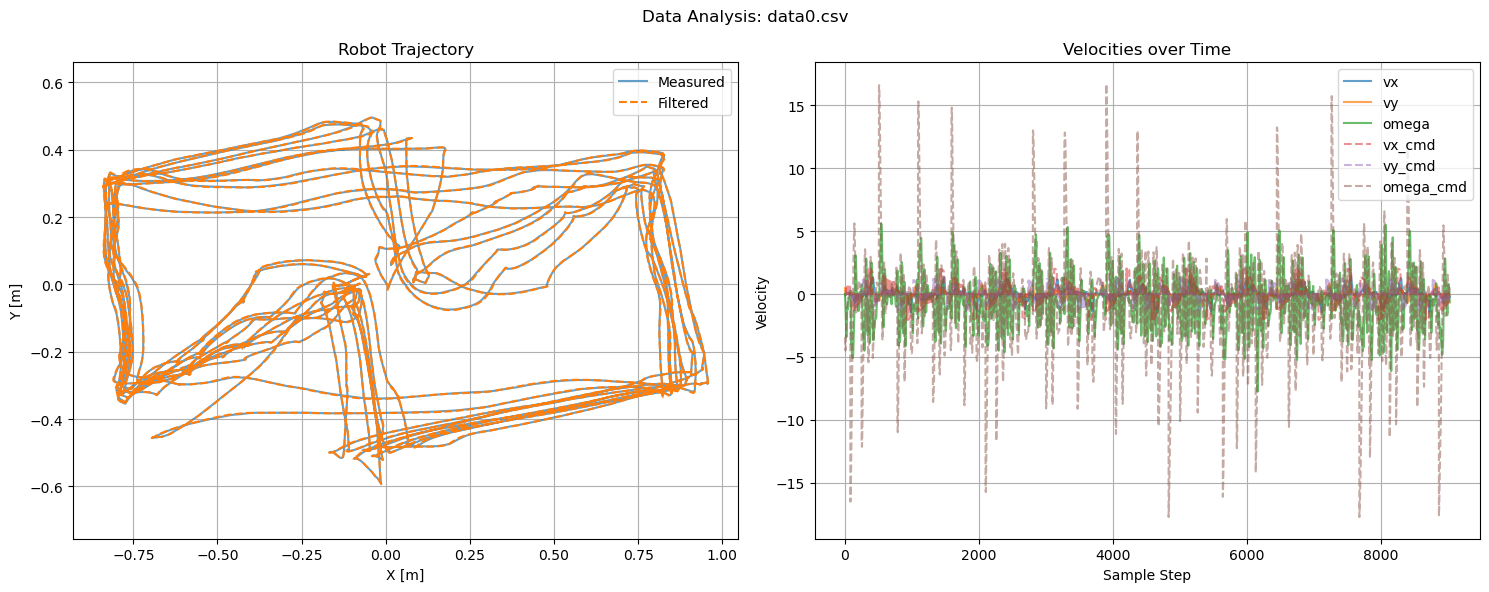

Processing data1.csv...


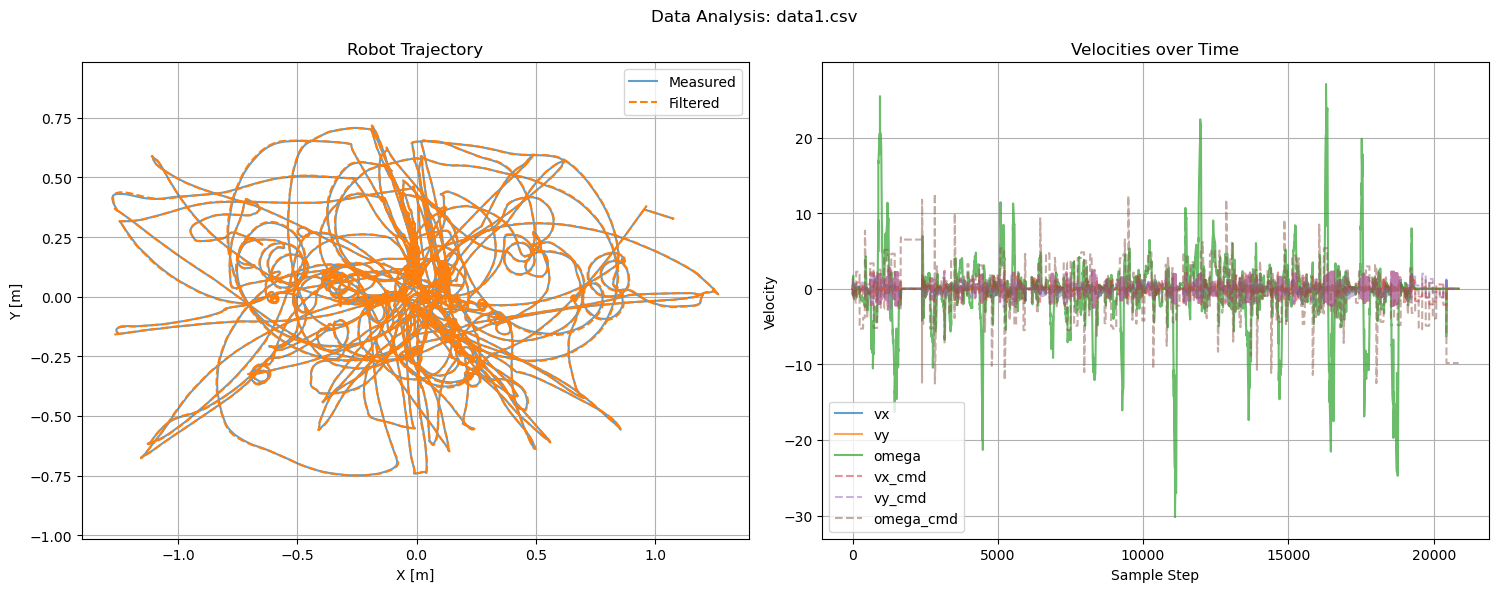

Processing data2.csv...


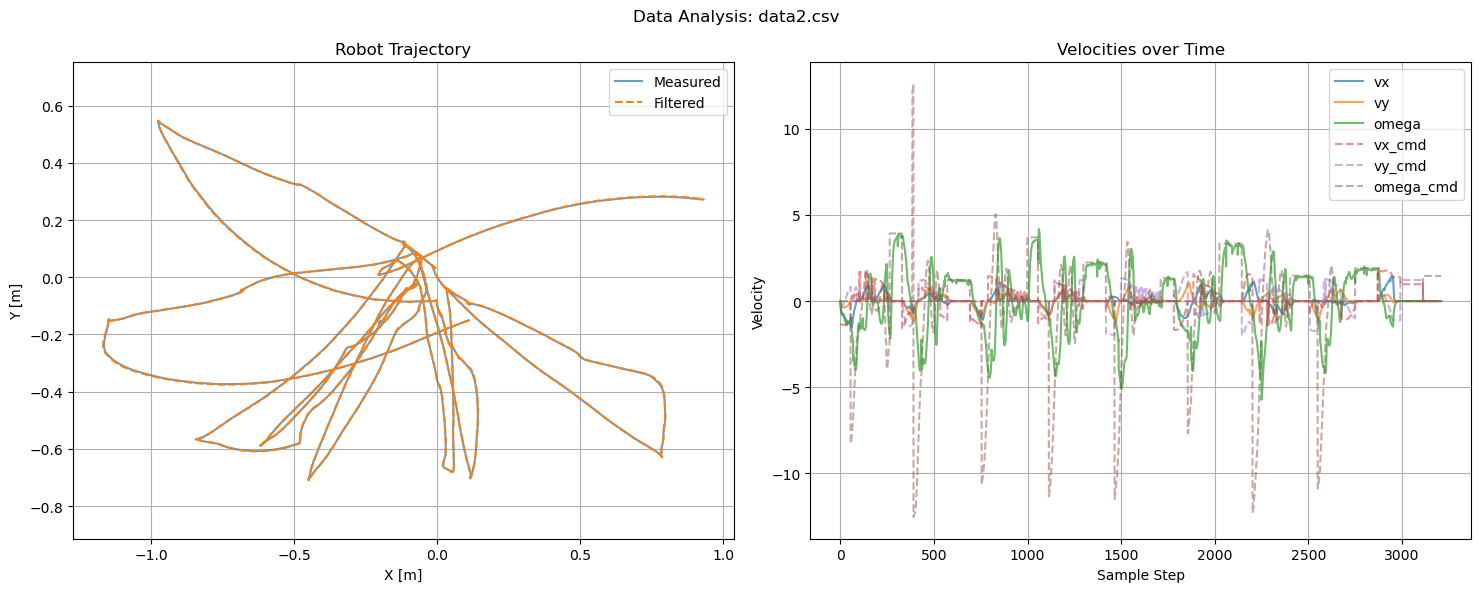

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob

def load_and_plot_processed_data(folder_path='processed_data'):
    # Find all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    
    if not csv_files:
        print(f"No CSV files found in {folder_path}")
        return

    for file_path in csv_files:
        filename = os.path.basename(file_path)
        print(f"Processing {filename}...")
        
        # Load data
        df = pd.read_csv(file_path, index_col=0)
        
        # Create a figure with 2 subplots: Trajectory and Velocities
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(f'Data Analysis: {filename}')
        
        # Plot 1: Trajectory (X vs Y)
        axes[0].plot(df['x'], df['y'], label='Measured', alpha=0.7)
        if 'filtered_x' in df.columns and 'filtered_y' in df.columns:
            axes[0].plot(df['filtered_x'], df['filtered_y'], label='Filtered', linestyle='--')
        axes[0].set_title('Robot Trajectory')
        axes[0].set_xlabel('X [m]')
        axes[0].set_ylabel('Y [m]')
        axes[0].legend()
        axes[0].grid(True)
        axes[0].axis('equal')

        # Plot 2: Velocities
        axes[1].plot(df.index, df['vx'], label='vx', alpha=0.7)
        axes[1].plot(df.index, df['vy'], label='vy', alpha=0.7)
        axes[1].plot(df.index, df['omega'], label='omega', alpha=0.7)
        
        # Plot commands if available (dashed)
        if 'vx_cmd' in df.columns:
            axes[1].plot(df.index, df['vx_cmd'], label='vx_cmd', linestyle='--', alpha=0.5)
        if 'vy_cmd' in df.columns:
            axes[1].plot(df.index, df['vy_cmd'], label='vy_cmd', linestyle='--', alpha=0.5)
        if 'omega_cmd' in df.columns:
            axes[1].plot(df.index, df['omega_cmd'], label='omega_cmd', linestyle='--', alpha=0.5)
            
        axes[1].set_title('Velocities over Time')
        axes[1].set_xlabel('Sample Step')
        axes[1].set_ylabel('Velocity')
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()

# Call the function
load_and_plot_processed_data()

In [11]:
import pandas as pd
import numpy as np

def load_time_series_data(file_path, steps):
    """
    Loads data from a CSV file and creates time series sequences of a specified length.

    Args:
        file_path (str): The path to the processed data CSV file.
        steps (int): The number of time steps (window size) for each sequence.

    Returns:
        np.ndarray: A numpy array containing the time series data with shape 
                    (n_samples, steps, n_features).
    """
    # Load the dataset
    # We assume index_col=0 based on the structure of your processed files
    df = pd.read_csv(file_path, index_col=0)
    # Extract the values as a numpy array
    data_values = df.values
    
    sequences = []
    
    # Create sliding window sequences
    # We loop such that we can extract a chunk of length 'steps' at each position
    for i in range(len(data_values) - steps + 1):
        window = data_values[i : i + steps]
        sequences.append(window)
        
    return np.array(sequences)

# Example usage:
file_path = 'processed_data/data0.csv'
steps = 8
time_series = load_time_series_data(file_path, steps)
print(f"Time series shape: {time_series.shape}")

Time series shape: (9026, 8, 10)


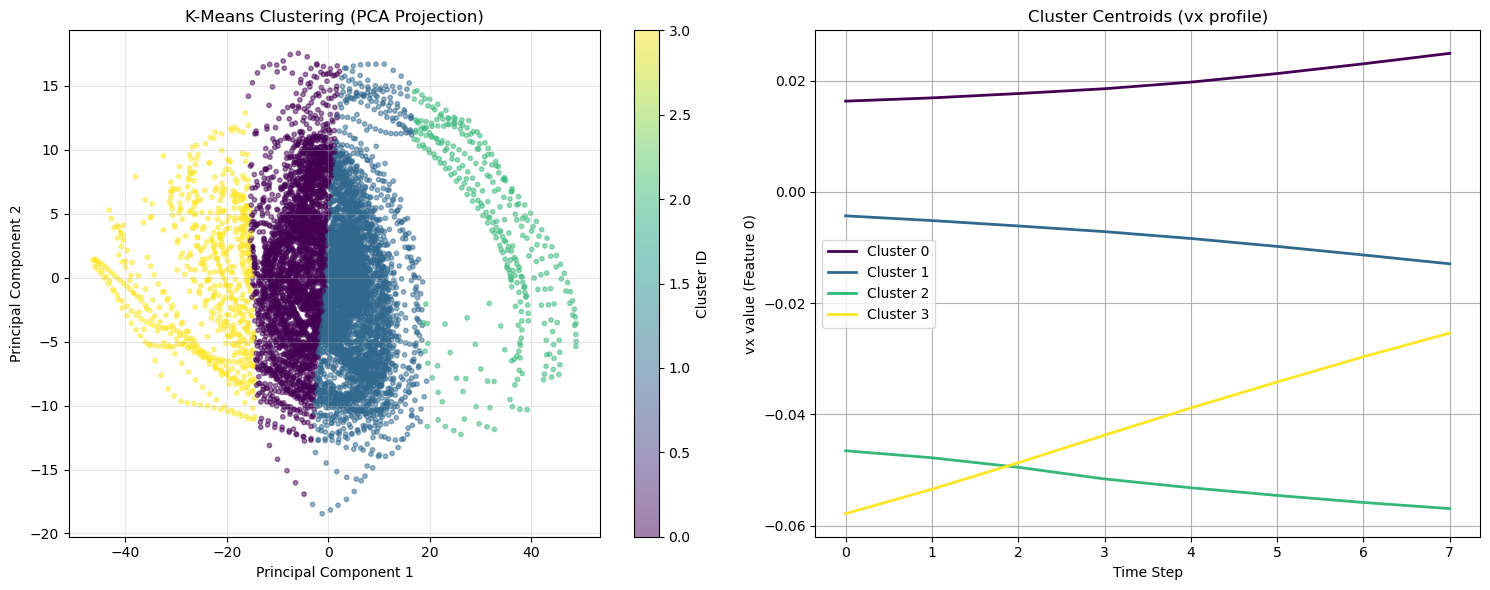

In [12]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def cluster_and_plot_time_series(time_series_data, n_clusters=3):
    """
    Clusters time series sequences using K-Means on the first 6 features 
    and plots the PCA-reduced clusters and centroid profiles.

    Args:
        time_series_data (np.ndarray): Input data of shape (n_samples, steps, n_features).
        n_clusters (int): Number of clusters to identify.
    """
    # 1. Use only the first 6 features
    # shape: (n_samples, steps, 6)
    data_subset = time_series_data[:, :, :6]
    
    n_samples, steps, n_features = data_subset.shape
    
    # 2. Flatten the time series for K-Means 
    # Transform (steps, 6) into a single vector of size steps*6 for each sample,
    # effectively treating the whole window as a single data point.
    flattened_data = data_subset.reshape(n_samples, -1)
    
    # 3. Apply K-Means algorithm
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(flattened_data)
    
    # 4. Reduce dimensionality for visualization (PCA -> 2D)
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(flattened_data)
    
    # 5. Plot results
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Left Plot: PCA Scatter
    scatter = axes[0].scatter(reduced_features[:, 0], reduced_features[:, 1], 
                              c=labels, cmap='viridis', alpha=0.5, s=10)
    axes[0].set_title('K-Means Clustering (PCA Projection)')
    axes[0].set_xlabel('Principal Component 1')
    axes[0].set_ylabel('Principal Component 2')
    plt.colorbar(scatter, ax=axes[0], label='Cluster ID')
    axes[0].grid(True, alpha=0.3)
    
    # Right Plot: Centroid Trajectories (Feature 0: vx)
    # Reshape centroids back to (steps, n_features) to view temporal pattern
    centroids = kmeans.cluster_centers_.reshape(n_clusters, steps, n_features)
    
    # Use the same colormap
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(vmin=0, vmax=n_clusters-1)
    
    for i in range(n_clusters):
        color = cmap(norm(i))
        # Plotting the profile of the first feature (vx) for the centroid
        axes[1].plot(centroids[i, :, 0], label=f'Cluster {i}', color=color, linewidth=2)
        
    axes[1].set_title('Cluster Centroids (vx profile)')
    axes[1].set_xlabel('Time Step')
    axes[1].set_ylabel('vx value (Feature 0)')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage:
cluster_and_plot_time_series(time_series, n_clusters=4)

c:\Users\Gerso\.conda\envs\motion_sim\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


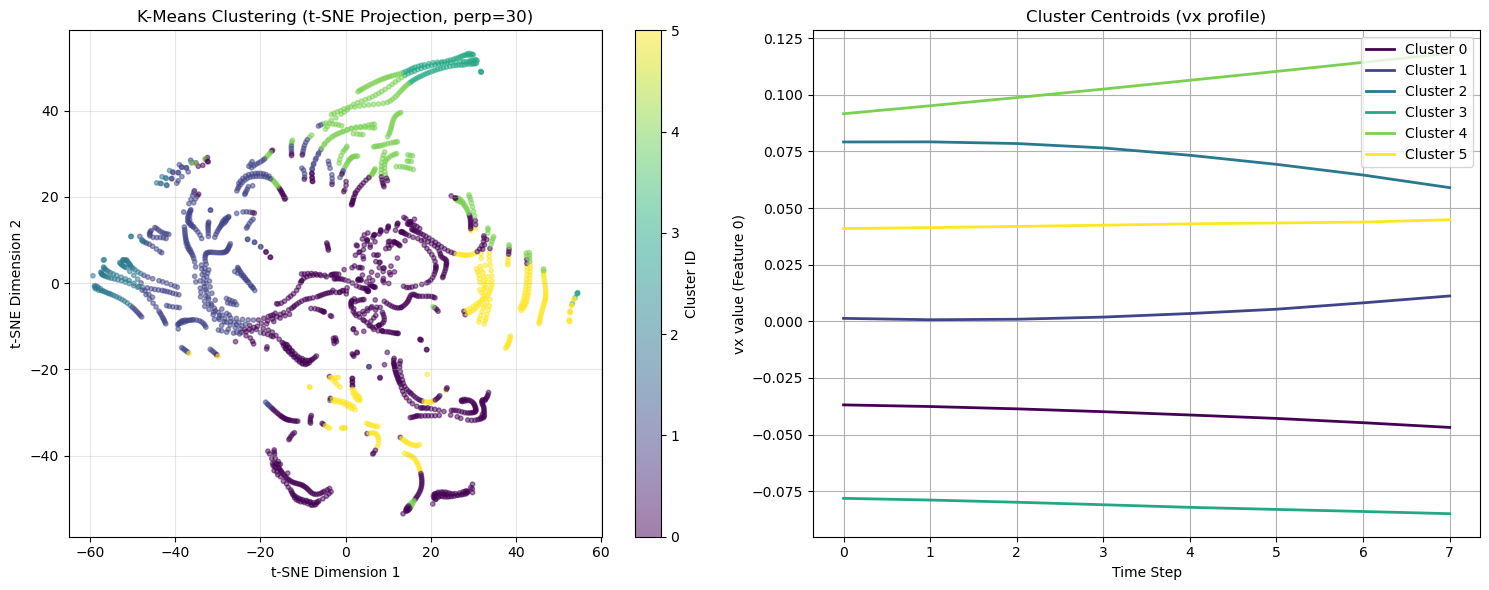

In [13]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def cluster_and_plot_time_series_tsne(time_series_data, n_clusters=3, perplexity=30):
    """
    Clusters time series sequences using K-Means on the first 6 features 
    and plots the t-SNE reduced clusters and centroid profiles.

    Args:
        time_series_data (np.ndarray): Input data of shape (n_samples, steps, n_features).
        n_clusters (int): Number of clusters to identify.
        perplexity (int): t-SNE perplexity parameter.
    """
    # 1. Use only the first 6 features
    data_subset = time_series_data[:, :, :6]
    n_samples, steps, n_features = data_subset.shape
    
    # 2. Flatten for K-Means and t-SNE
    flattened_data = data_subset.reshape(n_samples, -1)
    
    # 3. Apply K-Means algorithm
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(flattened_data)
    
    # 4. Reduce dimensionality with t-SNE
    # We use 'init="pca"' for better stability and faster convergence
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init='pca', learning_rate='auto')
    reduced_features = tsne.fit_transform(flattened_data)
    
    # 5. Plot results
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Left Plot: t-SNE Scatter
    scatter = axes[0].scatter(reduced_features[:, 0], reduced_features[:, 1], 
                              c=labels, cmap='viridis', alpha=0.5, s=10)
    axes[0].set_title(f'K-Means Clustering (t-SNE Projection, perp={perplexity})')
    axes[0].set_xlabel('t-SNE Dimension 1')
    axes[0].set_ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter, ax=axes[0], label='Cluster ID')
    axes[0].grid(True, alpha=0.3)
    
    # Right Plot: Centroid Trajectories (Feature 0: vx)
    centroids = kmeans.cluster_centers_.reshape(n_clusters, steps, n_features)
    
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(vmin=0, vmax=n_clusters-1)
    
    for i in range(n_clusters):
        color = cmap(norm(i))
        axes[1].plot(centroids[i, :, 0], label=f'Cluster {i}', color=color, linewidth=2)
        
    axes[1].set_title('Cluster Centroids (vx profile)')
    axes[1].set_xlabel('Time Step')
    axes[1].set_ylabel('vx value (Feature 0)')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage (may take a moment for large datasets):
# If dataset is very large, consider subsampling for t-SNE speed
cluster_and_plot_time_series_tsne(time_series[:2000], n_clusters=6)